<a href="https://colab.research.google.com/github/analativach/Backend-Flask/blob/main/fixberhasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project SIB 2024 - Stechoq: Kelompok 1***

## ***IMPORT LIBRARY***

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import os
import cv2
from skimage import exposure
from sklearn.model_selection import train_test_split
import shutil
import zipfile
from PIL import Image

## ***DATA LOAD & EKSPLORATION***

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"analativach221111009","key":"6976a8e12ea0ae8344e69caf6ec7d4cb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
os.environ['KAGGLE_USERNAME'] = "analativach221111009"
os.environ['KAGGLE_KEY'] = "6976a8e12ea0ae8344e69caf6ec7d4cb"
!kaggle datasets download -d analativach221111009/braintumor-mri-datasets

Dataset URL: https://www.kaggle.com/datasets/analativach221111009/braintumor-mri-datasets
License(s): unknown
 96% 142M/149M [00:01<00:00, 166MB/s]
100% 149M/149M [00:01<00:00, 131MB/s]


In [ ]:
# Tentukan path ke file ZIP
zip_file_path = 'braintumor-mri-datasets.zip'

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('finalproject_datasets')  # Folder tujuan tempat gambar diekstrak

In [ ]:
# Path ke folder yang berisi gambar-gambar
test_dir = 'finalproject_datasets/Testing'

# Path ke folder yang berisi gambar-gambar pengujian
data_dir = 'finalproject_datasets/Training'

In [ ]:
# Menghitung total data

import os

def count_dataset_files(directory):

  total_files = 0
  for root, _, files in os.walk(directory):
    total_files += len(files)
  return total_files

total_test_files = count_dataset_files(data_dir)
print(f"Total files in training dataset: {total_test_files}")

total_train_files = count_dataset_files(test_dir)
print(f"Total files in testing dataset: {total_train_files}")

total_dir = total_train_files + total_test_files
print(f"Total files in dataset: {total_dir}")

Total files in training dataset: 5712
Total files in testing dataset: 1311
Total files in dataset: 7023


Classes in Training Data: ['glioma', 'notumor', 'meningioma', 'pituitary']
Classes in Testing Data: ['glioma', 'notumor', 'meningioma', 'pituitary']

Number of images per class in Training Data:
glioma: 1321
notumor: 1595
meningioma: 1339
pituitary: 1457

Number of images per class in Testing Data:
glioma: 300
notumor: 405
meningioma: 306
pituitary: 300


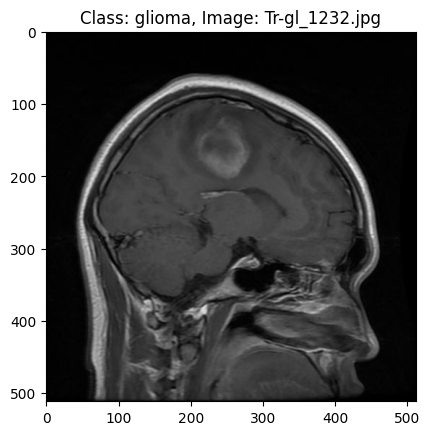

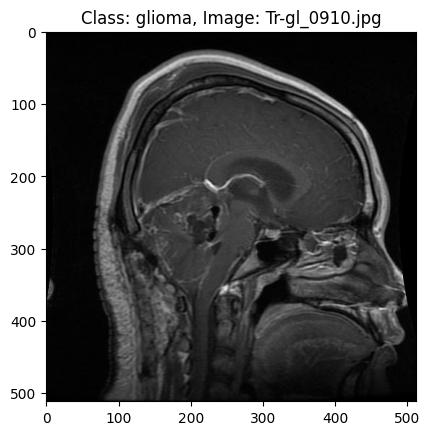

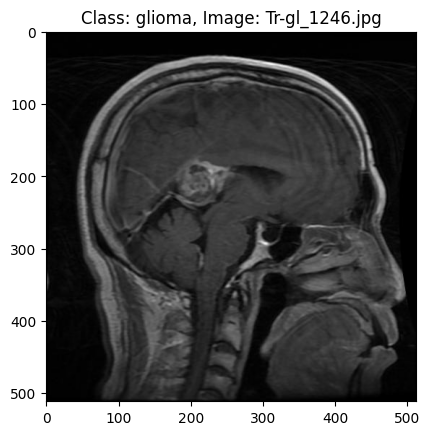

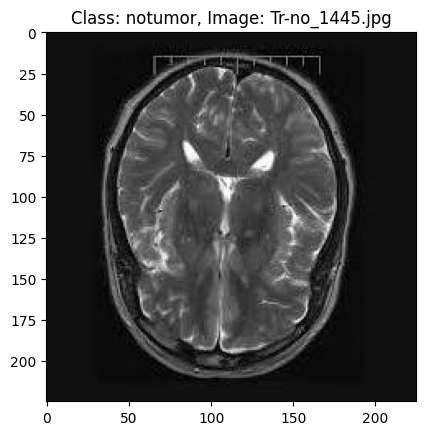

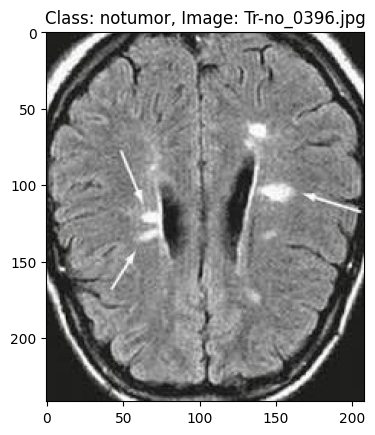

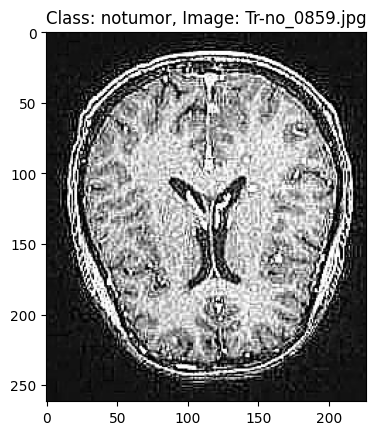

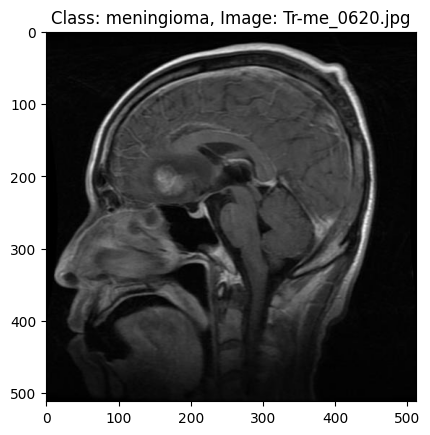

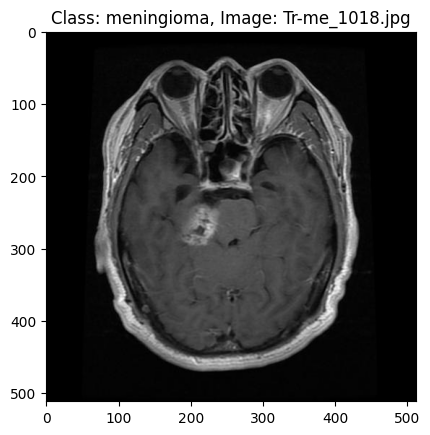

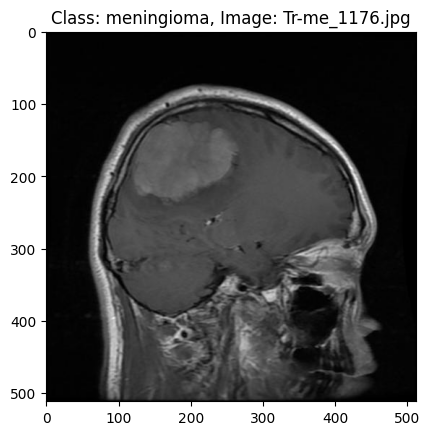

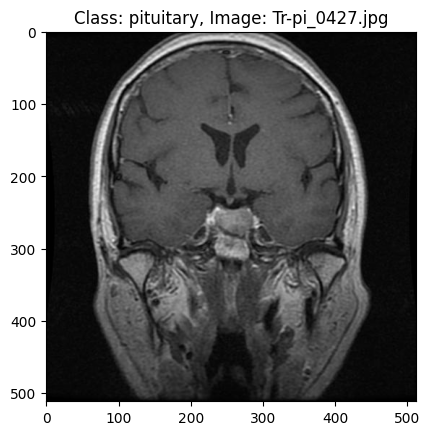

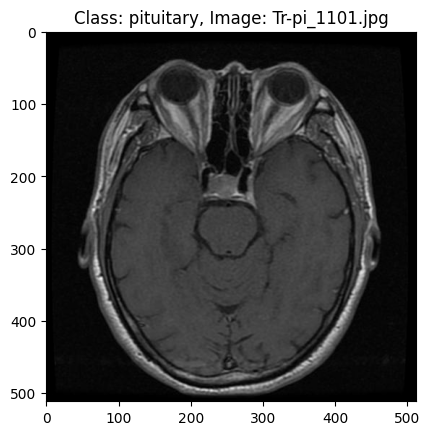

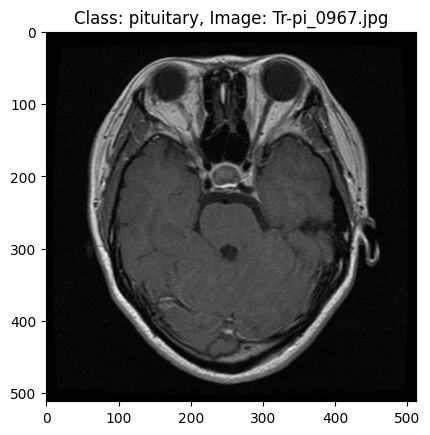

In [ ]:
print("Classes in Training Data:", os.listdir(data_dir))
print("Classes in Testing Data:", os.listdir(test_dir))

# Fungsi untuk Menghitung Gambar di Setiap Kelas
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Menghitung Jumlah Gambar di Direktori Training dan Testing
train_counts = count_images(data_dir)
test_counts = count_images(test_dir)

print("\nNumber of images per class in Training Data:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nNumber of images per class in Testing Data:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

# Menampilkan Beberapa Contoh Gambar dari Setiap Kelas
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for i, image_name in enumerate(os.listdir(class_dir)):
          if i < 3:  # Menampilkan 3 gambar per kelas
            img_path = os.path.join(class_dir, image_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Class: {class_name}, Image: {image_name}")
            plt.show()

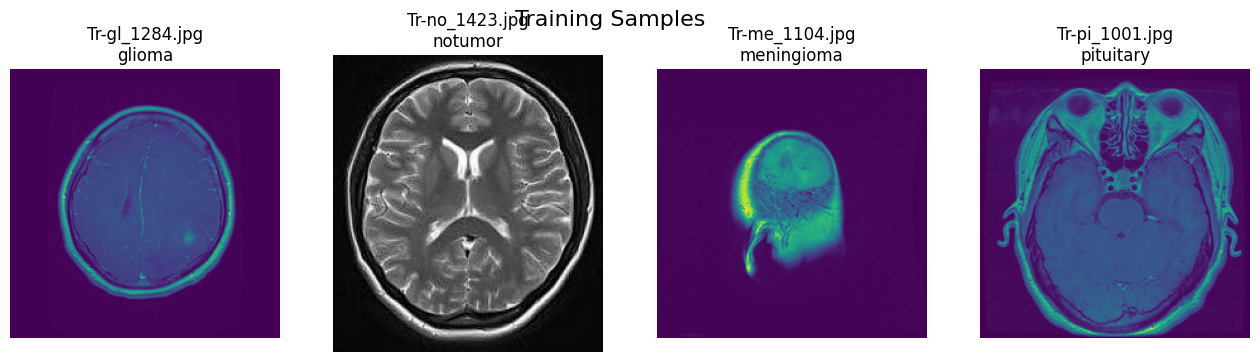

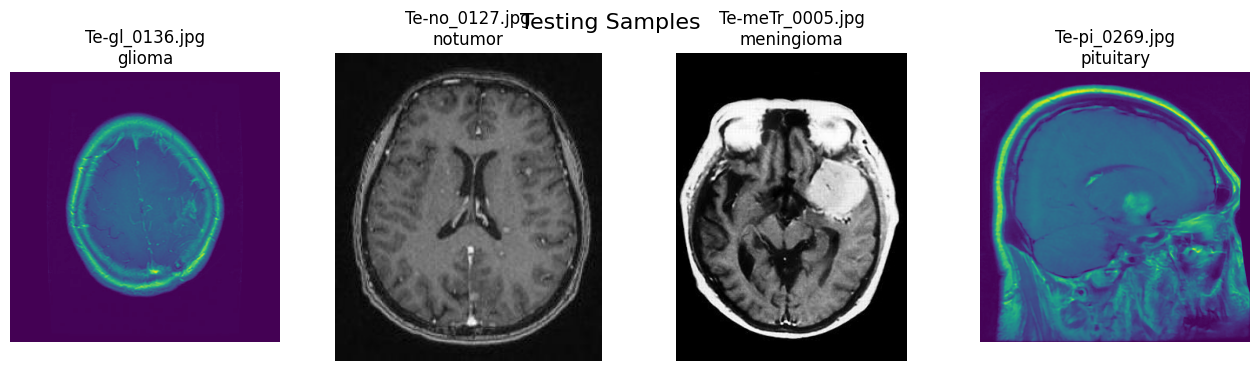

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Fungsi untuk menampilkan 1 gambar dari setiap subfolder dalam direktori yang ditentukan
def display_samples_from_subfolders(directory, title):
    # Dapatkan semua subfolder di dalam direktori
    subfolders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    sample_images = []

    # Ambil satu gambar dari setiap subfolder
    for subfolder in subfolders:
        all_images = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if all_images:
            sample_images.append(random.choice(all_images))  # Pilih satu gambar acak

    # Set ukuran plot
    plt.figure(figsize=(16, 4))  # Ukuran lebih besar untuk 4 gambar sejajar
    plt.suptitle(title, fontsize=16)

    # Tampilkan setiap gambar yang dipilih
    for i, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        plt.subplot(1, 4, i + 1)  # Mengatur 4 gambar dalam 1 baris
        plt.imshow(img)
        plt.axis('off')

        # Mendapatkan jenis tumor dari nama subdirektori
        tumor_type = os.path.basename(os.path.dirname(img_path))  # Mengambil nama subdirektori
        plt.title(f"{os.path.basename(img_path)}\n{tumor_type}")  # Menambahkan keterangan jenis tumor

    plt.show()

# Tampilkan 1 contoh gambar dari setiap subfolder dalam direktori Testing dan Training
display_samples_from_subfolders(data_dir, "Training Samples")
display_samples_from_subfolders(test_dir, "Testing Samples")

## ***PREPROCESSING DATA***

In [ ]:
# hapus duplikat

import os
import hashlib
from PIL import Image

def calculate_hash(image_path):
    with Image.open(image_path) as img:
        # Menghitung hash dari konten gambar
        hash_md5 = hashlib.md5(img.tobytes()).hexdigest()
    return hash_md5

# Path ke folder dataset
dataset_path = 'finalproject_datasets'

# Dictionary untuk menyimpan hash gambar yang sudah ditemukan
hashes = {}
duplicate_count = 0  # Inisialisasi di awal

# Looping untuk memeriksa setiap file di folder dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            # Hitung hash dari gambar
            file_hash = calculate_hash(file_path)

            # Jika hash sudah ada di dictionary, hapus file duplikat
            if file_hash in hashes:
                print(f"Duplikat ditemukan, menghapus {file_path}")
                os.remove(file_path)
                duplicate_count += 1  # Tambahkan ke count
            else:
                # Jika tidak ada, tambahkan ke dictionary
                hashes[file_hash] = file_path
        except Exception as e:
            print(f"Error saat memproses {file_path}: {e}")

# Setelah proses duplikasi, hitung total file yang tersisa setelah pembersihan
total_files_left = sum([len(files) for _, _, files in os.walk(dataset_path)])

# Menampilkan hasil
print(f"Total file duplikat yang dihapus: {duplicate_count}")
print(f"Total file yang tersisa di dataset: {total_files_left}")

Duplikat ditemukan, menghapus finalproject_datasets/Testing/glioma/Te-gl_0024.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0088.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0012.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0087.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0073.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0052.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0083.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-noTr_0001.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0019.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0084.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0044.jpg
Duplikat ditemukan, menghapus finalproject_datasets/Testing/notumor/Te-no_0048.jpg
Dup

In [ ]:
import os

# Path ke folder dataset
training_path = 'finalproject_datasets/Training'

# Dictionary untuk menyimpan jumlah file dalam setiap kelas
class_counts = {}

# Menghitung total file dan jumlah file berdasarkan kelas
total_files = 0

for root, dirs, files in os.walk(training_path):
    # Menghitung jumlah file dalam direktori ini
    total_files += len(files)

    # Menentukan nama kelas dari nama subfolder
    class_name = os.path.basename(root)

    # Jika folder bukan folder dataset, lanjutkan
    if class_name == os.path.basename(training_path):
        continue

    # Jika kelas belum ada dalam dictionary, tambahkan
    if class_name not in class_counts:
        class_counts[class_name] = 0

    # Menambahkan jumlah file ke kelas yang sesuai
    class_counts[class_name] += len(files)

# Menampilkan total file dan jumlah file per kelas
print(f"Total file di dalam folder dataset: {total_files}")
print("Jumlah file berdasarkan kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} file")

Total file di dalam folder dataset: 5316
Jumlah file berdasarkan kelas:
glioma: 1321 file
notumor: 1325 file
meningioma: 1230 file
pituitary: 1440 file


In [ ]:
import os
import cv2
import numpy as np
import gc

def enhance_contrast_histogram_equalization(image):
    """
    Tingkatkan kontras gambar menggunakan Histogram Equalization.
    Gambar harus dalam format RGB dan diterapkan pada setiap channel.
    """
    # Pisahkan setiap channel (R, G, B)
    channels = cv2.split(image)

    # Tingkatkan kontras masing-masing channel
    channels = [cv2.equalizeHist(channel) for channel in channels]

    # Gabungkan kembali channel
    return cv2.merge(channels)

def enhance_contrast_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Tingkatkan kontras gambar menggunakan CLAHE.
    Gambar harus dalam format RGB dan diterapkan pada setiap channel.
    """
    # Pisahkan setiap channel (R, G, B)
    channels = cv2.split(image)

    # Inisialisasi CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Tingkatkan kontras masing-masing channel
    channels = [clahe.apply(channel) for channel in channels]

    # Gabungkan kembali channel
    return cv2.merge(channels)

def normalize_and_enhance_contrast(input_folder, output_folder, method="clahe", clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Normalisasi dan tingkatkan kontras semua gambar di folder dan subfolder.

    Parameters:
    - input_folder: Folder input yang berisi gambar.
    - output_folder: Folder untuk menyimpan gambar hasil.
    - method: Metode kontras yang digunakan ("histogram" atau "clahe").
    - clip_limit, tile_grid_size: Parameter untuk CLAHE.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Path gambar input dan folder output
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, input_folder)
                output_subdir = os.path.join(output_folder, relative_path)

                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                output_path = os.path.join(output_subdir, file)

                try:
                    # Baca gambar sebagai RGB
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    if image is None:
                        print(f"Gambar tidak dapat dibaca: {image_path}")
                        continue

                    # Normalisasi gambar ke rentang [0, 1]
                    normalized_image = image.astype(np.float32) / 255.0

                    # Kembalikan ke rentang [0, 255] untuk peningkatan kontras
                    normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

                    # Tingkatkan kontras
                    if method == "histogram":
                        enhanced_image = enhance_contrast_histogram_equalization(normalized_image_uint8)
                    elif method == "clahe":
                        enhanced_image = enhance_contrast_clahe(normalized_image_uint8, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
                    else:
                        raise ValueError("Metode kontras tidak valid. Gunakan 'histogram' atau 'clahe'.")

                    # Simpan gambar hasil
                    cv2.imwrite(output_path, enhanced_image)
                    print(f"Gambar disimpan ke: {output_path}")

                    # Bersihkan memori
                    del image, normalized_image, normalized_image_uint8, enhanced_image
                    gc.collect()

                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# Contoh penggunaan
input_folder = 'finalproject_datasets'
output_folder = 'NormalizationEnhanced'
normalize_and_enhance_contrast(input_folder, output_folder, method="clahe", clip_limit=2.0, tile_grid_size=(8, 8))

Streaming output truncated to the last 5000 lines.
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_0781.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_1026.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_0320.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_1188.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_0723.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_1044.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_0826.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_1012.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_0783.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_1108.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_0983.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-gl_1092.jpg
Gambar disimpan ke: NormalizationEnhanced/Training/glioma/Tr-glTr_0002.jp

In [ ]:
# K-Means Segmentation

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gc  # Library untuk pengelolaan memori

def kmeans_segmentation(image, k=4):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels].reshape(image.shape)
    return segmented_image

def process_folder_with_kmeans(input_folder, output_folder, k=4):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)

                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)

                print(f"Memproses segmentasi K-Means untuk gambar: {image_path}")
                try:
                    image = cv2.imread(image_path)
                    if image is None:
                        print(f"Gambar tidak dapat dibaca: {image_path}")
                        continue

                    segmented_image = kmeans_segmentation(image, k=k)
                    output_path = os.path.join(output_subfolder, f"kmeans_{file}")
                    cv2.imwrite(output_path, segmented_image)

                    print(f"Gambar disimpan ke: {output_path}")  # Debug output

                    # Hapus gambar dari memori
                    del image
                    del segmented_image
                    gc.collect()  # Panggil garbage collector untuk membersihkan memori

                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# Contoh penggunaan
input_folder = 'NormalizationEnhanced'
output_folder = 'Kmeans'
k_clusters = 4

process_folder_with_kmeans(input_folder, output_folder, k=k_clusters)

Streaming output truncated to the last 5000 lines.
Memproses segmentasi K-Means untuk gambar: NormalizationEnhanced/Training/meningioma/Tr-me_0417.jpg
Gambar disimpan ke: Kmeans/Training/meningioma/kmeans_Tr-me_0417.jpg
Memproses segmentasi K-Means untuk gambar: NormalizationEnhanced/Training/meningioma/Tr-me_1154.jpg
Gambar disimpan ke: Kmeans/Training/meningioma/kmeans_Tr-me_1154.jpg
Memproses segmentasi K-Means untuk gambar: NormalizationEnhanced/Training/meningioma/Tr-me_0837.jpg
Gambar disimpan ke: Kmeans/Training/meningioma/kmeans_Tr-me_0837.jpg
Memproses segmentasi K-Means untuk gambar: NormalizationEnhanced/Training/meningioma/Tr-me_1167.jpg
Gambar disimpan ke: Kmeans/Training/meningioma/kmeans_Tr-me_1167.jpg
Memproses segmentasi K-Means untuk gambar: NormalizationEnhanced/Training/meningioma/Tr-me_0423.jpg
Gambar disimpan ke: Kmeans/Training/meningioma/kmeans_Tr-me_0423.jpg
Memproses segmentasi K-Means untuk gambar: NormalizationEnhanced/Training/meningioma/Tr-me_0318.jpg
Gamb

## ***TRAIN MODEL***

EfficienNetB0 revisi 2

Jumlah data: 5316


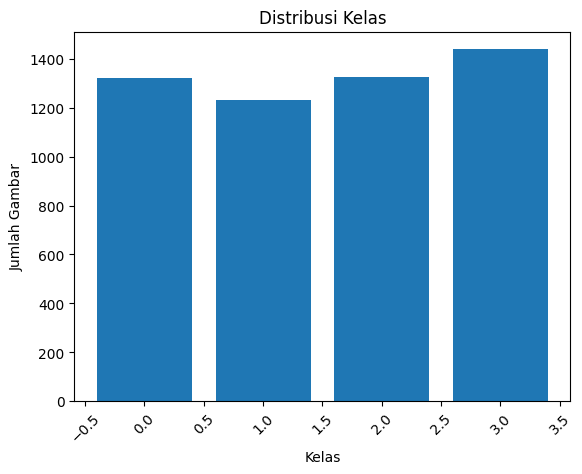

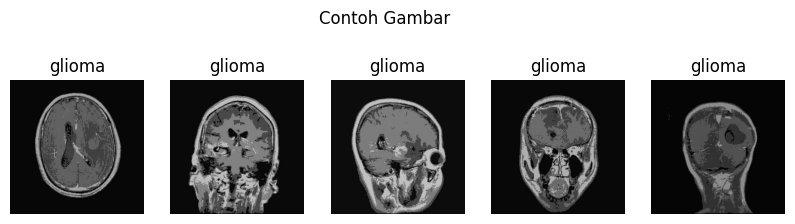

Epoch 1/30
266/266 [==============================] - 1252s 5s/step - loss: 0.4586 - accuracy: 0.8387 - val_loss: 0.2641 - val_accuracy: 0.9079
Epoch 2/30
266/266 [==============================] - 1232s 5s/step - loss: 0.1782 - accuracy: 0.9381 - val_loss: 0.1395 - val_accuracy: 0.9643
Epoch 3/30
266/266 [==============================] - 1224s 5s/step - loss: 0.0985 - accuracy: 0.9704 - val_loss: 0.0716 - val_accuracy: 0.9774
Epoch 4/30
266/266 [==============================] - 1226s 5s/step - loss: 0.0603 - accuracy: 0.9800 - val_loss: 0.0793 - val_accuracy: 0.9737
Epoch 5/30
266/266 [==============================] - 1225s 5s/step - loss: 0.0455 - accuracy: 0.9849 - val_loss: 0.0705 - val_accuracy: 0.9774
Epoch 6/30
266/266 [==============================] - 1226s 5s/step - loss: 0.0339 - accuracy: 0.9887 - val_loss: 0.0649 - val_accuracy: 0.9774
Epoch 7/30
266/266 [==============================] - 1221s 5s/step - loss: 0.0289 - accuracy: 0.9920 - val_loss: 0.0737 - val_accuracy:

In [1]:
import os
from keras.callbacks import EarlyStopping
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import models

def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)

    # Pemetaan label sesuai dengan klasifikasi tumor
    label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                if img_path.endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (224, 224))  # Resize image to match model input
                    images.append(img)
                    labels.append(label_map[class_name])  # Gunakan pemetaan label

    return np.array(images), np.array(labels)

def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_examples(images, labels, label_names, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):  # Menampilkan 5 gambar contoh
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(label_names[labels[i]])  # Menampilkan nama kelas, bukan angka
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def main():
    input_folder = 'Kmeans/Training'  # Path ke folder output sebelumnya

    # Load images
    images, labels = load_images_from_folder(input_folder)

    print(f"Jumlah data: {len(images)}")

    # Pemetaan label numerik ke nama kelas
    label_names = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

    # Plot distribusi kelas
    plot_class_distribution(labels, 'Distribusi Kelas')

    # Tampilkan contoh gambar
    plot_examples(images, labels, label_names, 'Contoh Gambar')

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)  # 80% training
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% validation, 10% testing

    # Prepare the EfficientNetB0 model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Ganti ke EfficientNetB0
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))  # Menambahkan dropout untuk mengurangi overfitting
    model.add(Dense(4, activation='softmax'))  # Sesuaikan dengan 4 kelas: glioma, meningioma, notumor, pituitary

    # Compile model dengan learning rate
    learning_rate = 0.0001  # Anda bisa menyesuaikan ini sesuai kebutuhan
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Convert predictions to class names
    y_pred_names = [label_names[label] for label in y_pred]

    # Display classification report with class names
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[label_names[i] for i in range(4)]))

    # Confusion Matrix (dengan nama kelas)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Hitung TP, TN, FP, FN
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

    # Save the model
    model.save('training_efficiennet.keras')
    model.save('efficientnet_tumor_model.h5')

if __name__ == "__main__":
    main()

EfficienNetB0 versi revisi


In [2]:
from tensorflow.keras.models import load_model

# Path ke file model
trained = load_model("efficientnet_tumor_model.h5")

# Menampilkan struktur model
trained.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [6]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model  # Import load_model

# Load the trained model
model = load_model('efficientnet_tumor_model.h5')  # Load the model

# Load and preprocess a new image
img_path = "Kmeans/Testing/glioma/kmeans_Te-gl_0010.jpg"

# Verify the file exists
if os.path.exists(img_path):
    new_image = cv2.imread(img_path)

    # Check if image was loaded successfully
    if new_image is not None:
        new_image = cv2.resize(new_image, (224, 224))
        new_image = np.expand_dims(new_image, axis=0)  # Tambahkan dimensi batch

        # Predict
        prediction = model.predict(new_image)
        predicted_class = np.argmax(prediction)
        print(f"Predicted Class: {predicted_class}")
    else:
        print(f"Error: Could not load image from {img_path}. Image might be corrupted or the path is incorrect.")
else:
    print(f"Error: File not found at {img_path}. Please check the path.")

1/1 [==============================] - 3s 3s/step
Predicted Class: 0


In [7]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model  # Import load_model

# Load the trained model
model = load_model('efficientnet_tumor_model.h5')  # Load the model

# Define class names (mapping from class index to class name)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Load and preprocess a new image
img_path = "Kmeans/Testing/glioma/kmeans_Te-gl_0010.jpg"

# Verify the file exists
if os.path.exists(img_path):
    new_image = cv2.imread(img_path)

    # Check if image was loaded successfully
    if new_image is not None:
        new_image = cv2.resize(new_image, (224, 224))
        new_image = np.expand_dims(new_image, axis=0)  # Tambahkan dimensi batch

        # Predict
        prediction = model.predict(new_image)
        predicted_class_index = np.argmax(prediction)  # Get the index of the predicted class
        predicted_class_name = class_names[predicted_class_index]  # Get the class name using the index

        print(f"Predicted Class: {predicted_class_name}")  # Print the class name
    else:
        print(f"Error: Could not load image from {img_path}. Image might be corrupted or the path is incorrect.")
else:
    print(f"Error: File not found at {img_path}. Please check the path.")

1/1 [==============================] - 2s 2s/step
Predicted Class: glioma


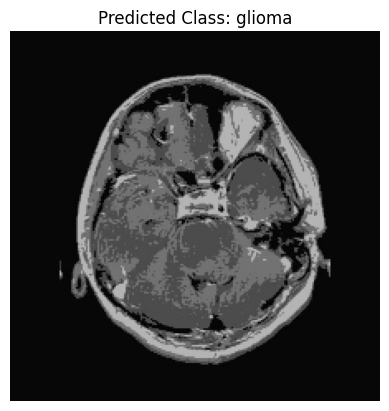

In [10]:
plt.imshow(cv2.cvtColor(new_image.squeeze(), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()

In [11]:
# Menyebutkan layer terakhir (biasanya output layer)
output_layer = model.layers[-1]

# Mengecek jumlah unit pada output layer
num_classes = output_layer.output_shape[1]
print(f"Jumlah kelas pada model: {num_classes}")

Jumlah kelas pada model: 4
